In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from pybaseball import team_game_logs, schedule_and_record

Get Mets data from 2013-2023

In [67]:
# Get the Mets game logs for the last 10 years
years = list(range(2013, 2024))  # Adjust this range as needed
frames = []

for year in years:
    logs = schedule_and_record(year, "NYM")
    # Remove the "(1)" style suffixes from the "Date" column
    logs['Date'] = logs['Date'].str.replace(r' \(\d+\)$', '', regex=True)
    logs['Date'] = logs['Date'] + f", {year}"
    # Convert the "Date" column to datetime format
    logs['Date'] = pd.to_datetime(logs['Date'], format='%A, %b %d, %Y')
    frames.append(logs)

http://www.baseball-reference.com/teams/NYM/2023-schedule-scores.shtml


In [68]:
all_data = pd.concat(frames)

# Filter for home games
home_games = all_data[all_data['Home_Away'] == 'Home']

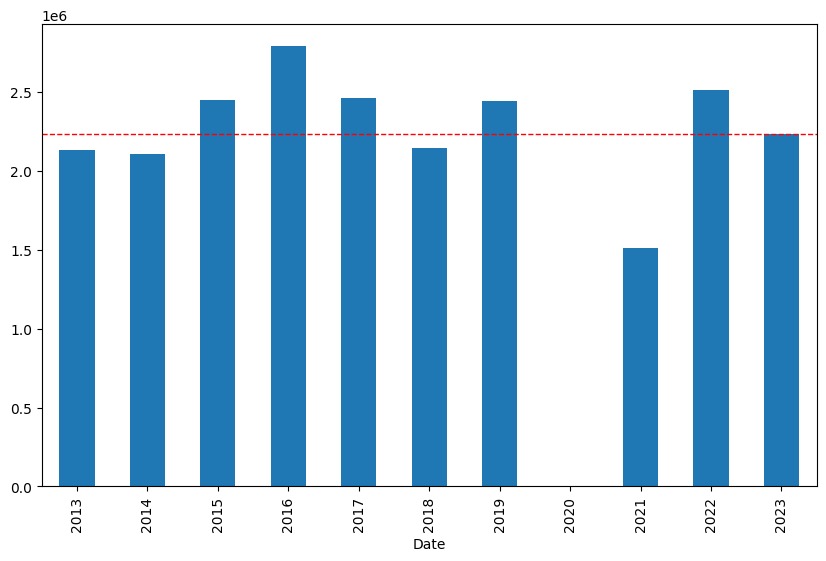

In [74]:
# Group by year and sum attendance
attendance_by_year = home_games.groupby(home_games['Date'].dt.year)['Attendance'].sum()

# Compute the average attendance
average_attendance = attendance_by_year.median()

# Plot
fig, ax = plt.subplots(figsize=(10,6))
attendance_by_year.plot(kind='bar', ax=ax)
ax.axhline(average_attendance, color='red', linestyle='dashed', linewidth=1)

/var/folders/pj/b56jspwd3tj8td90w8dwqmhh0000gn/T/ipykernel_91853/3259111082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_games['Year'] = home_games['Date'].dt.year
/var/folders/pj/b56jspwd3tj8td90w8dwqmhh0000gn/T/ipykernel_91853/3259111082.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_games['Month'] = home_games['Date'].dt.month


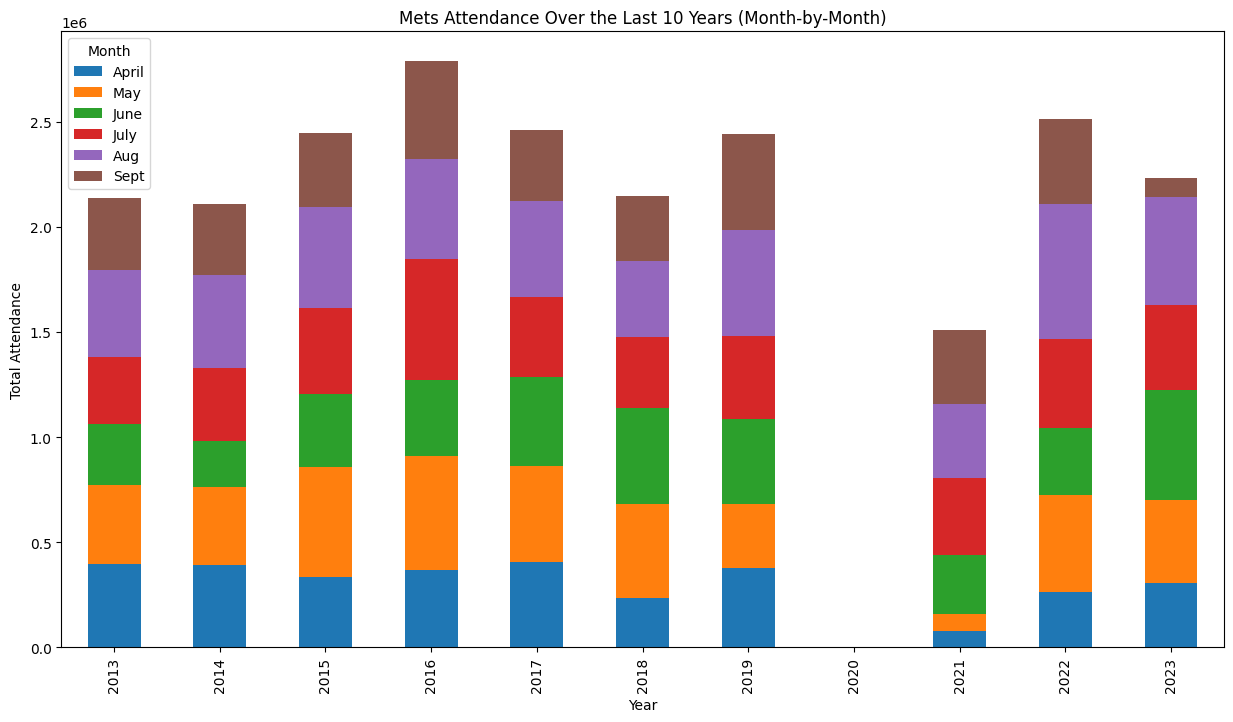

In [71]:
# Group by year and month, then sum attendance
home_games['Year'] = home_games['Date'].dt.year
home_games['Month'] = home_games['Date'].dt.month
home_games = home_games[home_games['Month'].isin([4, 5, 6, 7, 8, 9])]

attendance_by_month_year = home_games.groupby(['Year', 'Month'])['Attendance'].sum().unstack()

# Plot
attendance_by_month_year.plot(kind='bar', figsize=(15,8), stacked=True)
plt.title("Mets Attendance Over the Last 10 Years (Month-by-Month)")
plt.xlabel("Year")
plt.ylabel("Total Attendance")
plt.legend(title="Month", labels=['April', 'May', 'June', 'July', 'Aug', 'Sept'])
plt.show()

In [72]:
# Identify the best month for each year
attendance_by_month_year['Best Month'] = attendance_by_month_year.idxmax(axis=1)
attendance_by_month_year['Best Attendance'] = attendance_by_month_year.max(axis=1)

# Prepare a dictionary for month number to name conversion
month_map = {4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep'}
attendance_by_month_year['Best Month'] = attendance_by_month_year['Best Month'].replace(month_map)

# Display the best months and their attendance
best_months_table = attendance_by_month_year[['Best Month', 'Best Attendance']]

# Style the table
styled_table = best_months_table.style.bar(subset=['Best Attendance'], color='#d65f5f', align='left').format({
    'Best Attendance': "{:,.0f}"
}).set_properties(**{'text-align': 'left'}).set_caption("Best Months of Attendance Yearly")

styled_table

Month,Best Month,Best Attendance
Year,,
2013,Aug,"414,662"
2014,Aug,"441,538"
2015,May,"525,447"
2016,Jul,"574,784"
2017,May,"458,215"
2018,Jun,"458,861"
2019,Aug,"507,538"
2020,Jul,7
2021,Jul,"367,595"


In [73]:
best_months_table

Month,Best Month,Best Attendance
Year,,
2013,Aug,414662.0
2014,Aug,441538.0
2015,May,525447.0
2016,Jul,574784.0
2017,May,458215.0
2018,Jun,458861.0
2019,Aug,507538.0
2020,Jul,7.0
2021,Jul,367595.0


In [78]:
# Best day of the week for attendance
best_day = home_games.groupby(home_games['Date'].dt.day_name())['Attendance'].mean().idxmax()
day_of_week_attendance = home_games.groupby(home_games['Date'].dt.day_name())['Attendance'].mean()

print(day_of_week_attendance)
print(f"The best day for attendance is: {best_day}")


Date
Friday       31529.813008
Monday       26382.855072
Saturday     34077.679688
Sunday       31540.330709
Thursday     28101.383721
Tuesday      26309.376068
Wednesday    27095.495798
Name: Attendance, dtype: float64
The best day for attendance is: Saturday
The opponent that draws the most attendance is: NYY


In [81]:
# Opponents that bring in most attendance
opponent_attendance = home_games.groupby('Opp')['Attendance'].mean()
best_opponent = home_games.groupby('Opp')['Attendance'].mean().idxmax()

print(opponent_attendance)
print(f"The opponent that draws the most attendance is: {best_opponent}")

Opp
ARI    27133.310345
ATL    28329.290698
BAL    18979.000000
BOS    27512.400000
CHC    30194.088235
CHW    32109.625000
CIN    26909.275862
CLE    33002.333333
COL    29855.969697
DET    33988.333333
HOU    32683.000000
KCR    31418.400000
LAA    37634.833333
LAD    34654.645161
MIA    27794.458824
MIL    29110.272727
MIN    28455.400000
NYY    40755.826087
OAK    28950.600000
PHI    29686.369048
PIT    30805.625000
SDP    29801.133333
SEA    34138.166667
SFG    28627.375000
STL    28487.290323
TBR    28302.000000
TEX    28529.818182
TOR    30764.100000
WSN    28997.919540
Name: Attendance, dtype: float64
The opponent that draws the most attendance is: NYY
